In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import itertools
from shapely.geometry import Polygon
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display

import math
from matplotlib.collections import PolyCollection
from copy import deepcopy as dcopy
import pulp

In [2]:
url='https://www.janestreet.com/puzzles/tri-tri-again-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[10:11]))))

### Tri, Tri Again

Label the sides of a tetrahedron with 1, 17, 71, and 711. On the board presented
here, place the tetrahedron on one of the top 8 triangles, and roll it until it
reaches one of the bottom 8 triangles, such that whenever the tetrahedron is
touching the board (including its initial placement), the number on its base
equals the number on the board. What is the lowest possible sum of numbers that
your tetrahedron encounters?

<img src="https://www.janestreet.com/puzzles/oct16_puzzle.png" width="600" >

In [3]:
# code to draw the board
def generate_unit_triangles(image_width, image_height):
    h = math.sin(math.pi / 3)
    count = 0
    for y in range(int(image_height / h)):
        for x in range(image_width):    
            yield [(x+1+count, y * h), (x+1.5+count, (y+1) * h), (x+0.5+count, (y+1) * h)]
            yield [(x+count+1, y * h), (x+2+count, y * h), (x+1.5+count, (y+1) * h)]
        count -=0.5

def print_board(board):
    nums = list(np.ravel(board))
    colors=[]
    for i in nums:
        if i == 1: colors.append("yellow")
        elif i == 71: colors.append("w")
        elif i == 711: colors.append("r")
        elif i == 17: colors.append("lime")
        else: colors.append("w")

    fig, ax = plt.subplots(figsize=(12,6)) 
    tris = [*generate_unit_triangles(8,7)]
    coll = PolyCollection(tris)
    coll.set_facecolors(colors)
    coll.set_edgecolors("grey")

    count = 0
    for t in tris:
        x= Polygon(t).centroid.x
        y= Polygon(t).centroid.y
        if nums[count] != 0:
            ax.text(x-len(str(nums[count]))*.07,y,nums[count]weight='bold')
        count +=1
    
    ax.invert_yaxis()    
    ax.add_collection(coll)
    ax.autoscale_view()
    ax.axis("off")        
    plt.show()

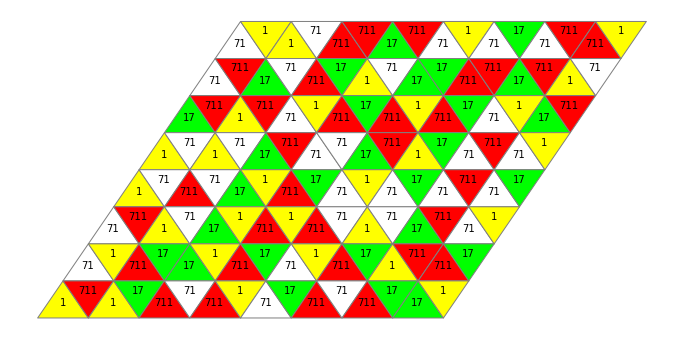

In [4]:
board = np.array([[71, 1, 1, 71, 711, 711, 17, 711, 71, 1, 71, 17, 71, 711, 711, 1],
                  [71, 711, 17, 71, 711, 17, 1, 71, 17, 17, 711, 711, 17, 711, 1, 71],
                  [17, 711, 1, 711, 71, 1, 711, 17, 711, 1, 711, 17, 71, 1, 17, 711],
                  [1, 71, 1, 71, 17, 711, 71, 71, 17, 711, 1, 17, 71, 711, 71, 1],
                  [1, 71, 711, 71, 17, 1, 711, 17, 71, 1, 71, 17, 71, 711, 71, 17],
                  [71, 711, 1, 71, 17, 1, 711, 1, 711, 71, 1, 71, 17, 711, 71, 1],
                  [71, 1, 711, 17, 17, 1, 711, 17, 71, 1, 711, 17, 1, 711, 711, 17],
                  [1, 711, 1, 17, 711, 71, 711, 1, 71, 17, 711, 71, 711, 17, 17, 1]]
                 ,dtype=int)

print_board(board)

In [5]:
# find the neighbours of the current cell
def neighbours(i,j):
    n =[]
    if j-1 >=0:
            n.append([i,j-1])
    if j+1 < 16:
            n.append([i,j+1]) 
            
    if j % 2 == 0:
        if i+1 < 8 and j+1 < 16:
            n.append([i+1,j+1])        
    else:
        if i-1 >= 0:
            n.append([i-1,j-1]) 
    return n

#roll the dice and determine if the roll is valid, returning the new dice
def roll(dice,grid,x,y,i,j):
    new_dice = dcopy(dice)
    p,a,b,c,d = new_dice
    if p == 0: 
        if x-i ==0 and y-j ==-1:
            new_dice = [1,b,d,c,a]
        elif x-i ==0 and y-j == 1:
            new_dice = [1,a,c,d,b]
        else:
            new_dice = [1,d,b,a,c]
            
    if p == 1: 
        if x-i ==0 and y-j ==-1:
            new_dice = [0,a,d,b,c]
        elif x-i ==0 and y-j == 1:
            new_dice = [0,d,a,c,b]
        else:
            new_dice = [0,c,b,d,a]
     
    
    if new_dice[4]== grid[i,j]:
        return True,new_dice
    else:
        return False,[]

# run through all possible paths
def solver(grid):
    poss_route = []
    for n in range(16):
        for d in itertools.permutations([1,17,71,711],4):
            visited = np.zeros((8,16),dtype=int)
            visited[0,n] =1
            if d[3] == grid[0,n] and n % 2 ==1:
                poss_route.append([[[0,n]], grid[0,n],visited,[n % 2]+list(d)])  #Route, Score, Points visited,dice
    
    max_route =[]
    best_score = 1000000
    while len(poss_route) > 0:
        route,score,visited,dice = poss_route.pop(0)
        if score > best_score:
            continue
        x,y = [*route[-1]]
        for [a,b] in neighbours(x,y):
            if a== 7 and b %2 ==0:
                good_roll,new_dice = roll(dice,grid,x,y,a,b)
                if good_roll:
                    if score+grid[a,b] < best_score:
                        new_visited = dcopy(visited)
                        new_visited[a,b] = 1
                        max_route = [route+[[a,b]], score+grid[a,b],new_visited,new_dice]
                        best_score = score+grid[a,b]
                    
            elif visited[a,b] != 1:
                good_roll,new_dice = roll(dice,grid,x,y,a,b)
                if good_roll:
                    new_visited = dcopy(visited)
                    new_visited[a,b] = 1
                    
                    poss_route.append([route+[[a,b]], score+grid[a,b],new_visited,new_dice])
                    
    return max_route 

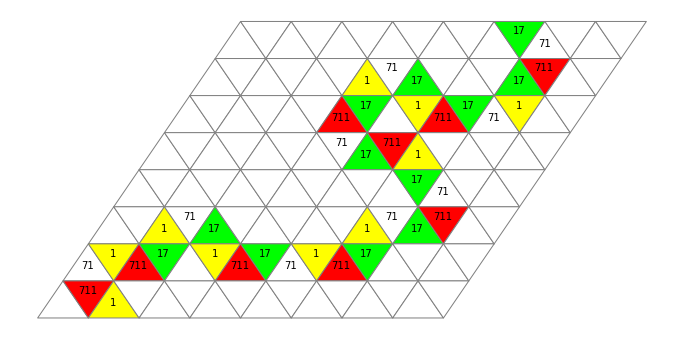

The solution is **7252** took 0.1237 seconds

In [6]:
start = time.time()
solved = solver(board)[2]
print_board(solved * board)
display(Markdown("The solution is **{}** took {:.4f} seconds".format(np.sum(solved*board),time.time()-start)))

In [7]:
url='https://www.janestreet.com/puzzles/tri-tri-again-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[10:15]))))

### October 2016 : Solution

As it turns out there are very few paths the tetrahedron can take from top to
bottom, and the shortest/cheapest one is presented here. The sum of the numbers
the tetrahedron rolls over on its path is
7252
.
Astute solvers noticed that for a tetrahedron with sides A, B, C, and D, when it
rolls in a “straight line” (such as moves 2 thru 5 in this solution), the faces
on the paper form the pattern ABCDABCD…, and when it begins to roll in a
“circle” (such as the one begun by moves 1 thru 4 in this solution), the faces
on the paper form the pattern ABCABCABC… . From there, one can logically deduce
the path the tetrahedron must take.
Congratulations to everyone who solved this month’s puzzle!

<img src="https://www.janestreet.com/puzzles/Oct16_Solution.png" width="600" >